## Imports

In [226]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import matplotlib as mpl
mpl.rc('font', family='Georgia')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
os.makedirs('figures', exist_ok=True)

## Reading and preparing data

### Algorithm 1: CMA-ES

Fitness data from training

In [228]:
ENEMIES = [1,3,4]

DATA_FOLDER_CMAES = os.path.join('data', 'cmaes')
cmaes_data = []

for (i, enemy) in enumerate(ENEMIES):
    cmaes_data.append(np.load(DATA_FOLDER_CMAES + f"/{enemy}/all_fitnesses_static.npy"))

cmaes_data = np.array(cmaes_data)
_, n_runs, n_gens, population_size = cmaes_data.shape
print(cmaes_data.shape)

(3, 10, 100, 100)


Gain data from testing

In [229]:
N_REPEATS = 5

cmaes_gains = np.zeros((len(ENEMIES), N_REPEATS * n_runs))

for (i, enemy) in enumerate(ENEMIES):
    cmaes_gains[i] = np.load(os.path.join(DATA_FOLDER_CMAES, f'{enemy}', 'gains.npy'))

Decision data from training

In [230]:
# 3rd dimension: Mean & STD
# 4th dimension: Left, Right, Jump, Shoot, Release
cmaes_decisions = np.zeros((len(ENEMIES), n_runs, n_gens, 2, 7))

for (i, enemy) in enumerate(ENEMIES):
    cmaes_decisions[i] = np.load(os.path.join('data', 'cmaes', f'{enemy}', 'all_decisions_static.npy'))

cmaes_decisions_mean = np.mean(cmaes_decisions, axis=1)
cmaes_decisions_std = np.std(cmaes_decisions, axis=1)

### Algorithm 2: NEAT

Fitness data from training

In [231]:
ENEMIES = [1,3,4]

DATA_FOLDER_NEAT = os.path.join('data', 'neat')
neat_data = []

for (i, enemy) in enumerate(ENEMIES):
    neat_data.append(np.load(DATA_FOLDER_NEAT + f"/{enemy}/all_fitnesses_static.npy"))

neat_data = np.array(neat_data)
_, n_runs, n_gens, population_size = neat_data.shape
print(neat_data.shape)

(3, 10, 100, 110)


Gain data from testing

In [232]:
N_REPEATS = 5

neat_gains = np.zeros((len(ENEMIES), N_REPEATS * n_runs))

for (i, enemy) in enumerate(ENEMIES):
    neat_gains[i] = np.load(os.path.join(DATA_FOLDER_NEAT, f'{enemy}', 'gains.npy'))

Decision data from training

In [233]:
# 3rd dimension: Mean & STD
# 4th dimension: Left, Right, Jump, Shoot, Release
neat_decisions = np.zeros((len(ENEMIES), n_runs, n_gens, 2, 7))

for (i, enemy) in enumerate(ENEMIES):
    neat_decisions[i] = np.load(os.path.join('data', 'neat', f'{enemy}', 'all_decisions_static.npy'))

neat_decisions_mean = np.mean(neat_decisions, axis=1)
neat_decisions_std = np.std(neat_decisions, axis=1)

## Fitness convergence

In [234]:
# Max fitness among individuals
cmaes_max = np.max(cmaes_data, axis=3)
print(cmaes_max.shape)

# Hall-of-fame variant instead of generational max
cmaes_hof = np.zeros(cmaes_max.shape)

for i in range(len(ENEMIES)):
    for j in range(n_runs):
        for k in range(1, n_gens):
            cmaes_hof[i,j,k] = max(cmaes_max[i,j,k], cmaes_hof[i,j,k-1])

# Average & SD across runs
cmaes_avg_max = np.mean(cmaes_max, axis=1)
cmaes_sd_max = np.std(cmaes_max, axis=1)

cmaes_avg_hof = np.mean(cmaes_hof, axis=1)
cmaes_sd_hof = np.std(cmaes_hof, axis=1)

# Mean fitness among individuals
cmaes_mean = np.mean(cmaes_data, axis=3)
print(cmaes_mean.shape)

# Average & SD across runs
cmaes_avg_mean = np.mean(cmaes_mean, axis=1)
cmaes_sd_mean = np.std(cmaes_mean, axis=1)

(3, 10, 100)
(3, 10, 100)


In [235]:
# Max fitness among individuals
neat_max = np.nanmax(neat_data, axis=3)
print(neat_max.shape)

# Average & SD across runs
neat_avg_max = np.mean(neat_max, axis=1)
neat_sd_max = np.std(neat_max, axis=1)

# Mean fitness among individuals
neat_mean = np.nanmean(neat_data, axis=3)

# Average & SD across runs
neat_avg_mean = np.mean(neat_mean, axis=1)
neat_sd_mean = np.std(neat_mean, axis=1)

(3, 10, 100)


### Fitness plot with both mean, max and HOF-max for CMA-ES

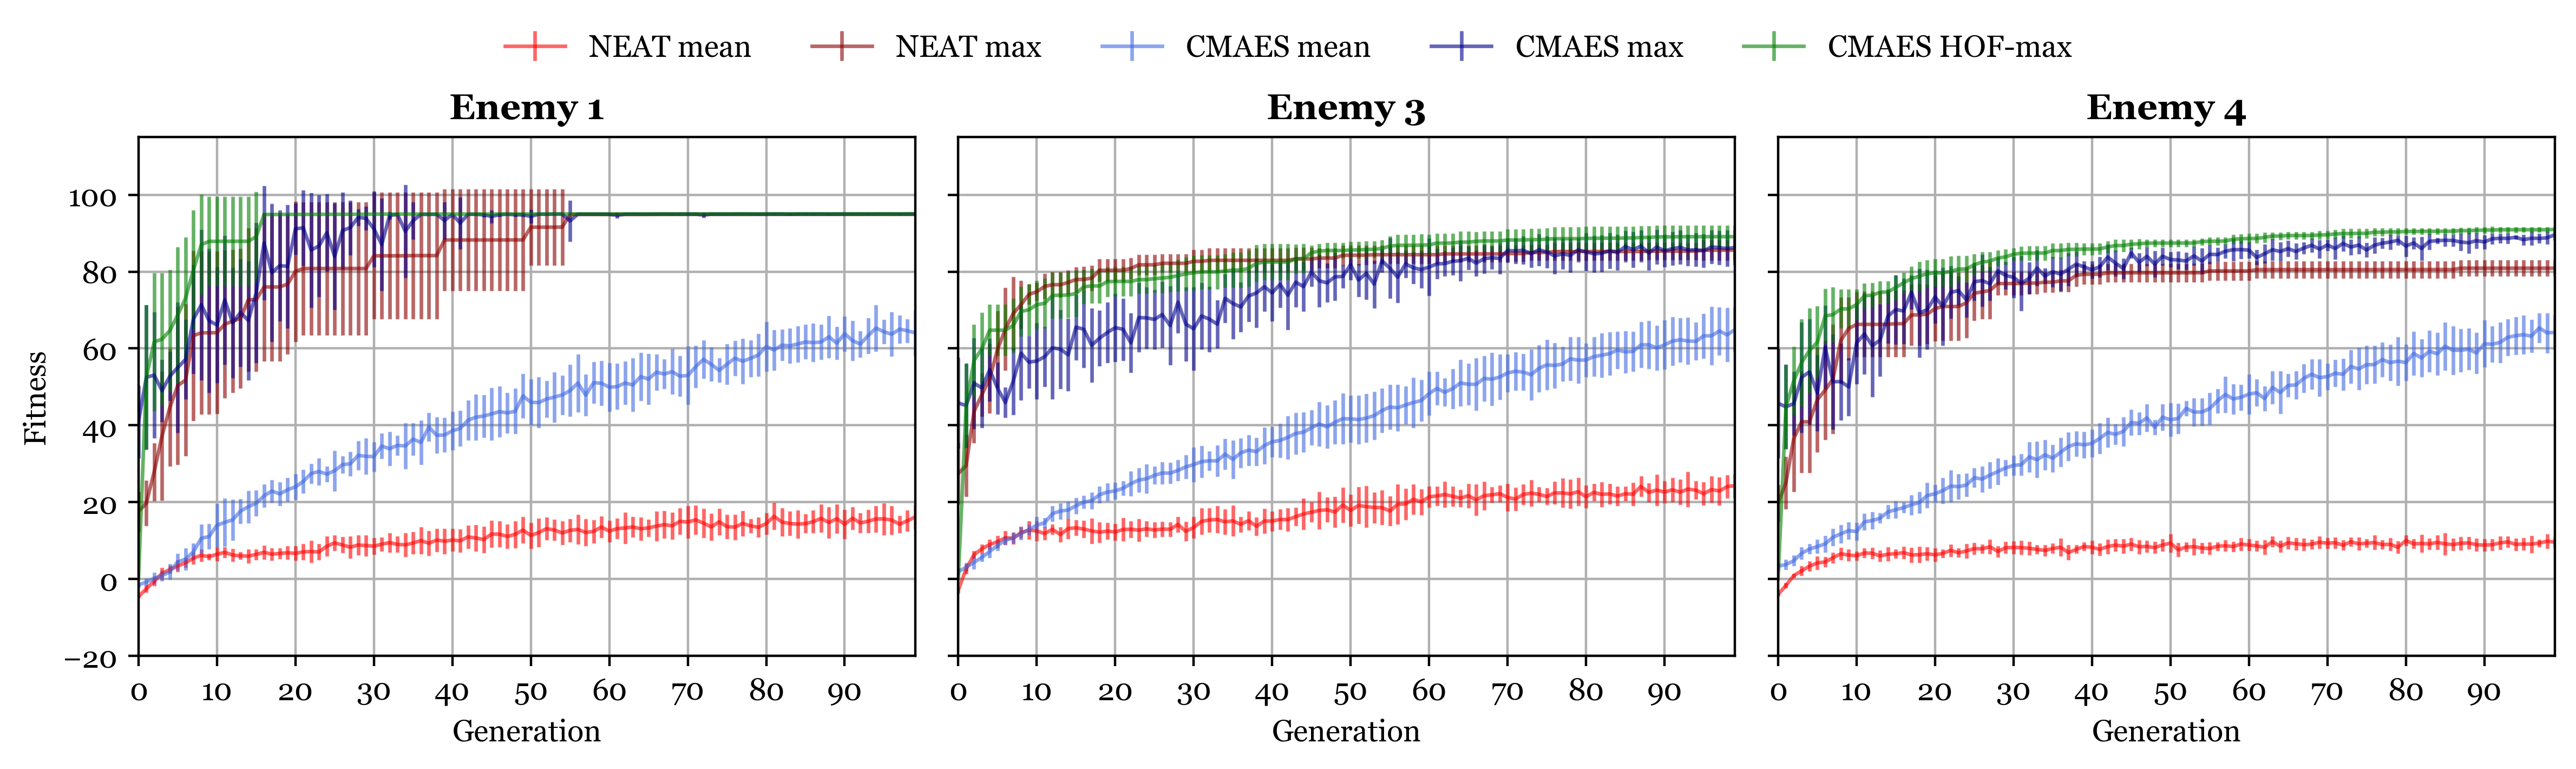

In [236]:
fig, axes = plt.subplots(1, len(ENEMIES), figsize=(12, 3.5), dpi=400, sharey=True)

for (i, enemy) in enumerate(ENEMIES):
    axes[i].set_ylim(-20, 115)
    axes[i].set_yticks(np.arange(-20, 101, 20))
    if i == 0:
        axes[i].set_ylabel("Fitness")
    axes[i].set_xlim(0, n_gens - 1)
    axes[i].set_xticks(np.arange(0, n_gens, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

lines = []
labels = []
for i in range(len(ENEMIES)):
    line1 = axes[i].errorbar(range(n_gens), neat_avg_mean[i], yerr=neat_sd_mean[i], alpha=0.6, lw=1.2, color="red", label="NEAT mean")
    line2 = axes[i].errorbar(range(n_gens), neat_avg_max[i], yerr=neat_sd_max[i], alpha=0.6, lw=1.2, color="darkred", label="NEAT max")
    line3 = axes[i].errorbar(range(n_gens), cmaes_avg_mean[i], yerr=cmaes_sd_mean[i], alpha=0.6, lw=1.2, color="royalblue", label="CMAES mean")
    line4 = axes[i].errorbar(range(n_gens), cmaes_avg_max[i], yerr=cmaes_sd_max[i], alpha=0.6, lw=1.2, color="darkblue", label="CMAES max")
    line5 = axes[i].errorbar(range(n_gens), cmaes_avg_hof[i], yerr=cmaes_sd_hof[i], alpha=0.6, lw=1.2, color="green", label="CMAES HOF-max")

    if i == 0:
        lines.extend([line1, line2, line3, line4, line5])
        labels.extend(["NEAT mean", "NEAT max", "CMAES mean", "CMAES max", "CMAES HOF-max"])

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(lines, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02), fontsize=10, frameon=False)
fig.savefig("figures/convergence.png", dpi=400)
plt.show()

Alternative visualization

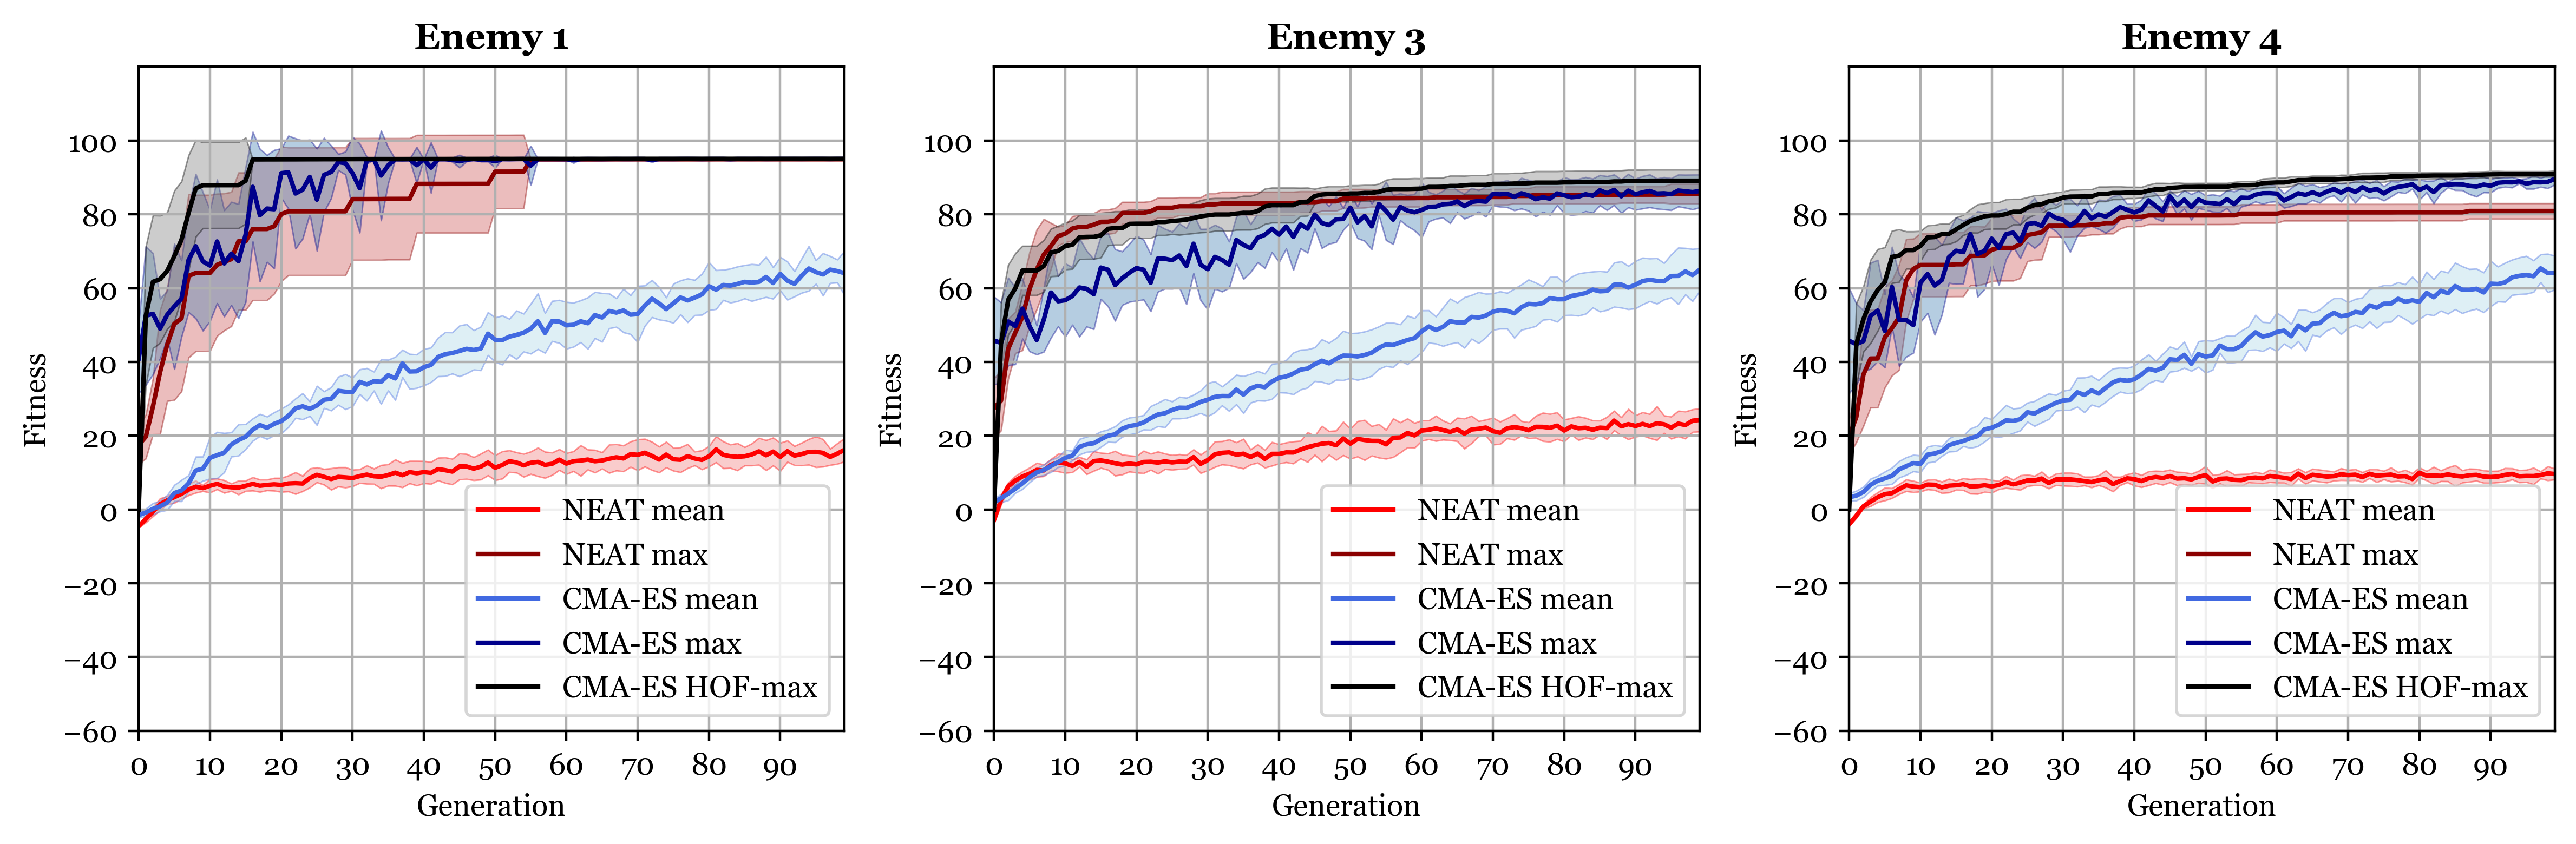

In [237]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
xx = np.arange(0, n_gens, 1, dtype=int)

def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    ax.plot(xx, means, color=color, linestyle=linestyle, lw=1.5, label=label)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color, alpha=0.4, edgecolor=color, linewidth=0.5)

for (i, enemy) in enumerate(ENEMIES):
    axes[i].set_ylim(-50, 120)
    axes[i].set_yticks(np.arange(-60, 120, 20))
    axes[i].set_ylabel("Fitness")
    axes[i].set_xlim(0, n_gens - 1)
    axes[i].set_xticks(np.arange(0, n_gens, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

for i in range(len(ENEMIES)):
    plot_mean_with_sd(axes[i], xx, neat_avg_mean[i], neat_sd_mean[i], color="red", fill_color="lightcoral", label="NEAT mean")
    plot_mean_with_sd(axes[i], xx, neat_avg_max[i], neat_sd_max[i], color="darkred", fill_color="indianred", label="NEAT max")
    plot_mean_with_sd(axes[i], xx, cmaes_avg_mean[i], cmaes_sd_mean[i], color="royalblue", fill_color="lightblue", label="CMA-ES mean")
    plot_mean_with_sd(axes[i], xx, cmaes_avg_max[i], cmaes_sd_max[i], color="darkblue", fill_color="steelblue", label="CMA-ES max")
    plot_mean_with_sd(axes[i], xx, cmaes_avg_hof[i], cmaes_sd_hof[i], color="black", fill_color="grey", label="CMA-ES HOF-max")
    axes[i].legend(loc="lower right")

fig.tight_layout()
fig.savefig("figures/convergence_v2.png", dpi=400)
plt.show()

### Optional: all runs

for CMA-ES just using HOF-max, no usual population max

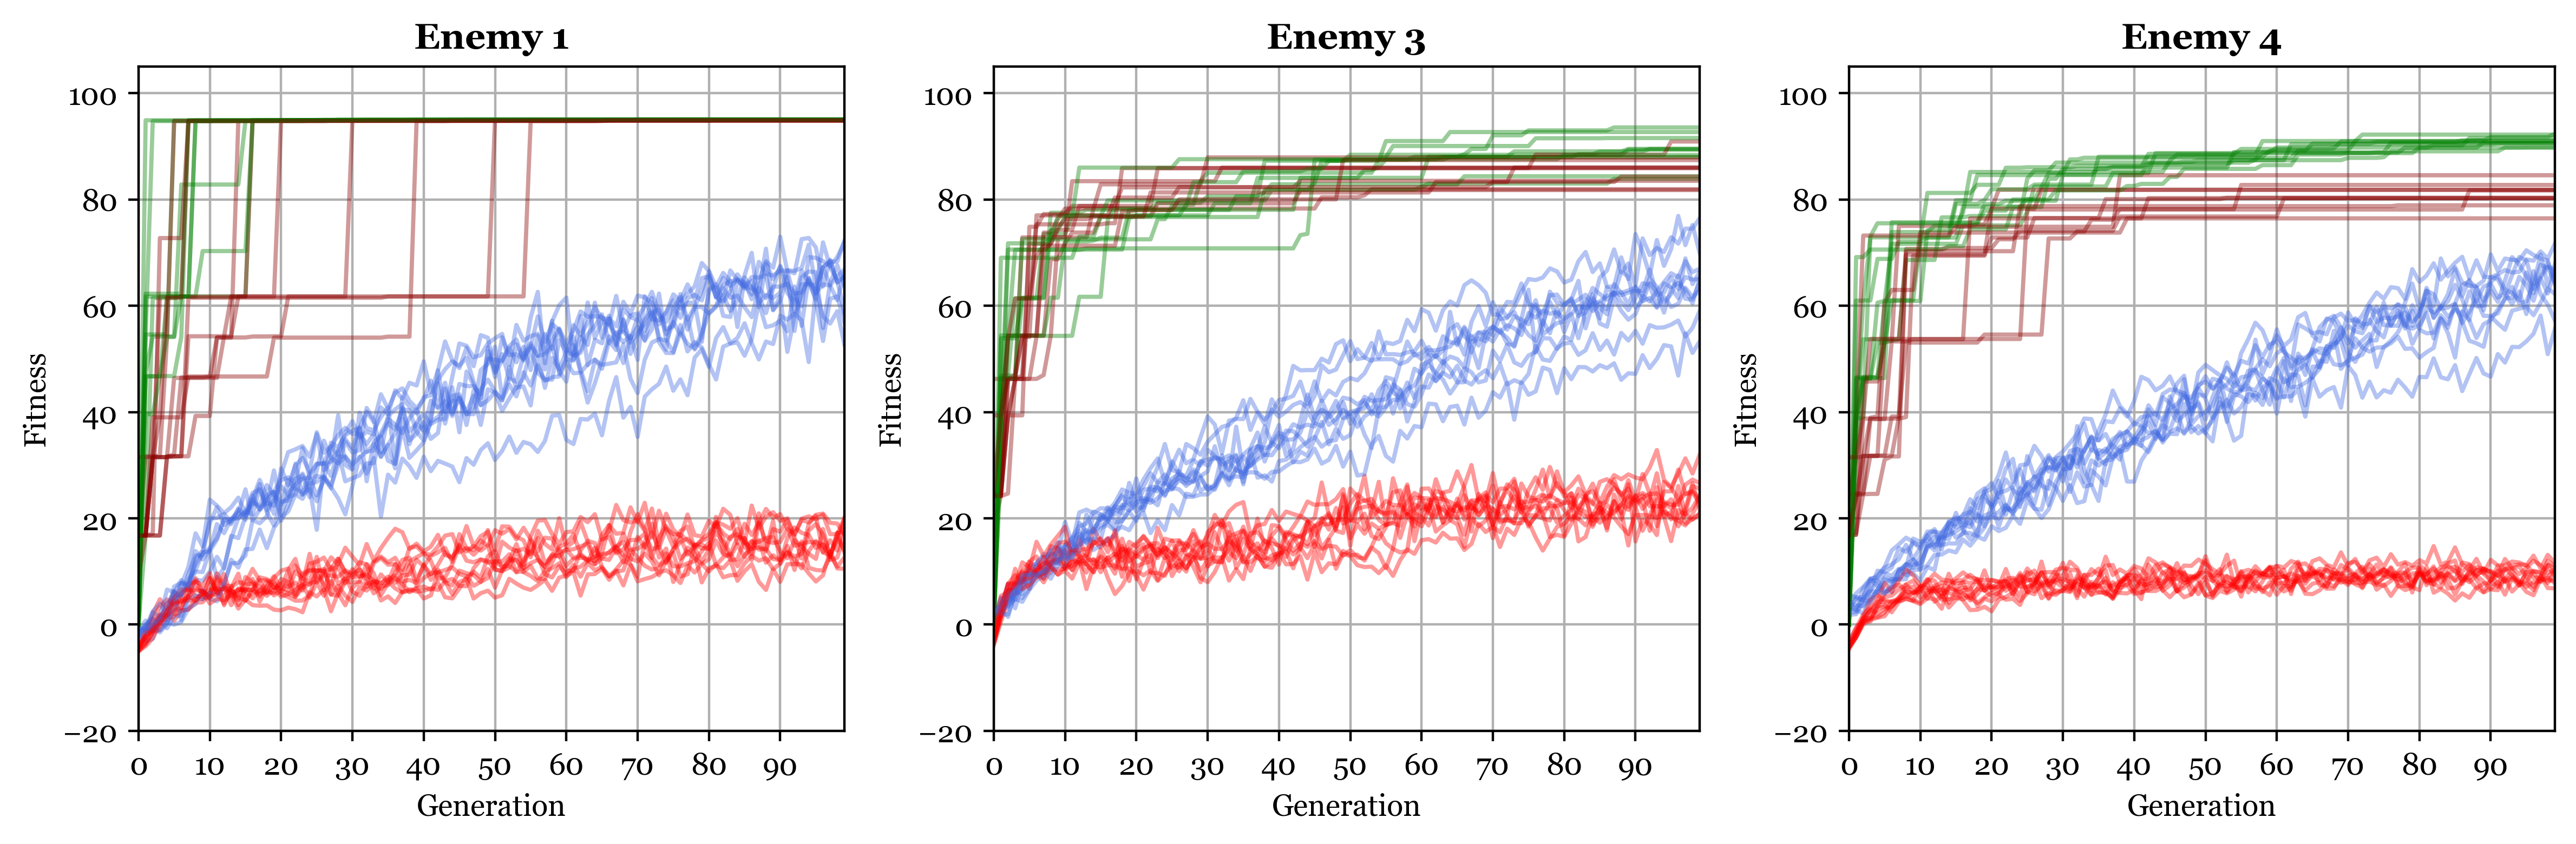

In [238]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=400)

def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    ax.plot(means, color=color, linestyle=linestyle, lw=2.5, label=label)
    ax.plot(means + sds, color=color, linestyle=linestyle, lw=1.25)
    ax.plot(means - sds, color=color, linestyle=linestyle, lw=1.25)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color)

for (i, enemy) in enumerate(ENEMIES):
    axes[i].set_ylim(-20, 105)
    axes[i].set_yticks(np.arange(-20, 101, 20))
    axes[i].set_ylabel("Fitness")
    axes[i].set_xlim(0, n_gens - 1)
    axes[i].set_xticks(np.arange(0, n_gens, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy {enemy}", weight="bold")
    axes[i].grid()

for i in range(len(ENEMIES)):
    for j in range(n_runs):
        axes[i].plot(range(n_gens), cmaes_hof[i, j], alpha=0.4, lw=1.4, color='green')
        # axes[i].plot(range(n_gens), cmaes_max[i, j], alpha=0.4, lw=1.4, color='darkblue')
        axes[i].plot(range(n_gens), cmaes_mean[i, j], alpha=0.4, lw=1.4, color='royalblue')
        axes[i].plot(range(n_gens), neat_max[i, j], alpha=0.4, lw=1.4, color='darkred')
        axes[i].plot(range(n_gens), neat_mean[i, j], alpha=0.4, lw=1.4, color='red')

fig.tight_layout()
fig.savefig("figures/fitness_all_runs.png", dpi=400)
plt.show()

## Gain performance on enemies

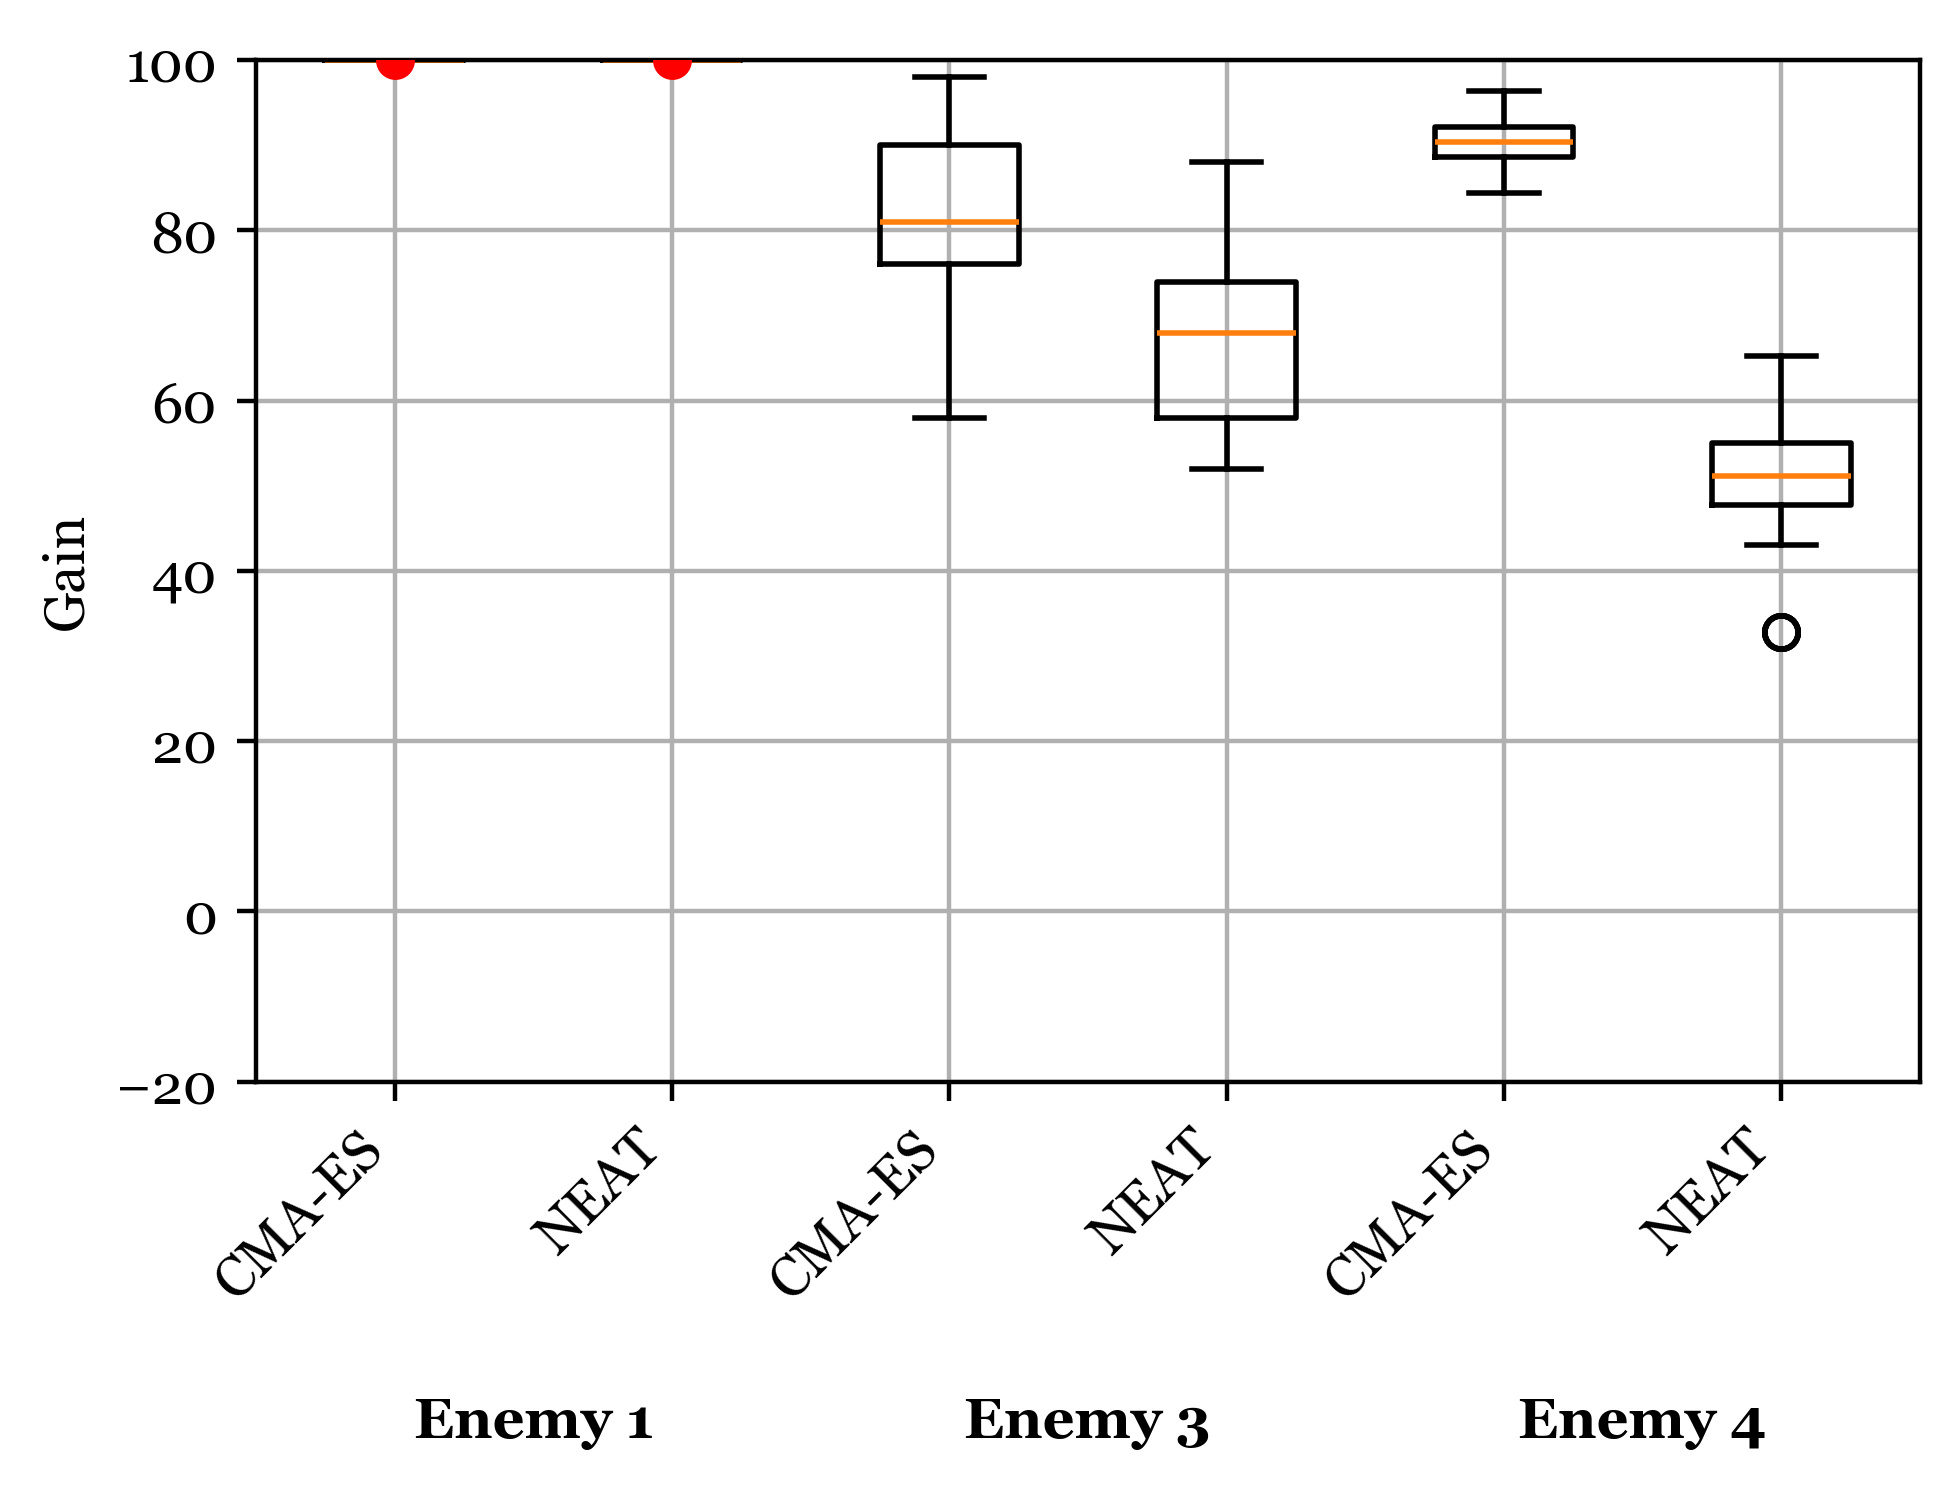

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=400)

all_gains = []
labels = []
for i in range(len(ENEMIES)):
    all_gains.append(cmaes_gains[i])
    all_gains.append(neat_gains[i])
    labels.append(f'CMA-ES')
    labels.append(f'NEAT')

ax.boxplot(all_gains)
ax.set_xticklabels(labels, rotation=45, ha='right')

enemy_index = 0
cmaes_mean = np.mean(cmaes_gains[enemy_index])
neat_mean = np.mean(neat_gains[enemy_index])
ax.scatter(1, cmaes_mean, color='red', zorder=5)
ax.scatter(2, neat_mean, color='red', zorder=5)

ax.set_ylim(-20, 100)
ax.set_yticks(np.arange(-20, 101, 20))
ax.set_ylabel("Gain")
ax.grid()

for i, enemy in enumerate(ENEMIES):
    ax.text(2*i + 1.5, -60, f'Enemy {enemy}', ha='center', va='center', fontsize=10, weight='bold')

fig.tight_layout()
fig.savefig("figures/test_gain.png", dpi=400)
plt.show()

Statistical significance in difference of means

In [240]:
for i in range(len(ENEMIES)):
    print(ttest_ind(cmaes_gains[i], neat_gains[i]).pvalue)

nan
2.2503334202662934e-07
2.2078355190477788e-51


/opt/homebrew/Caskroom/miniconda/base/envs/evoman/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


### Decisions and Strategies

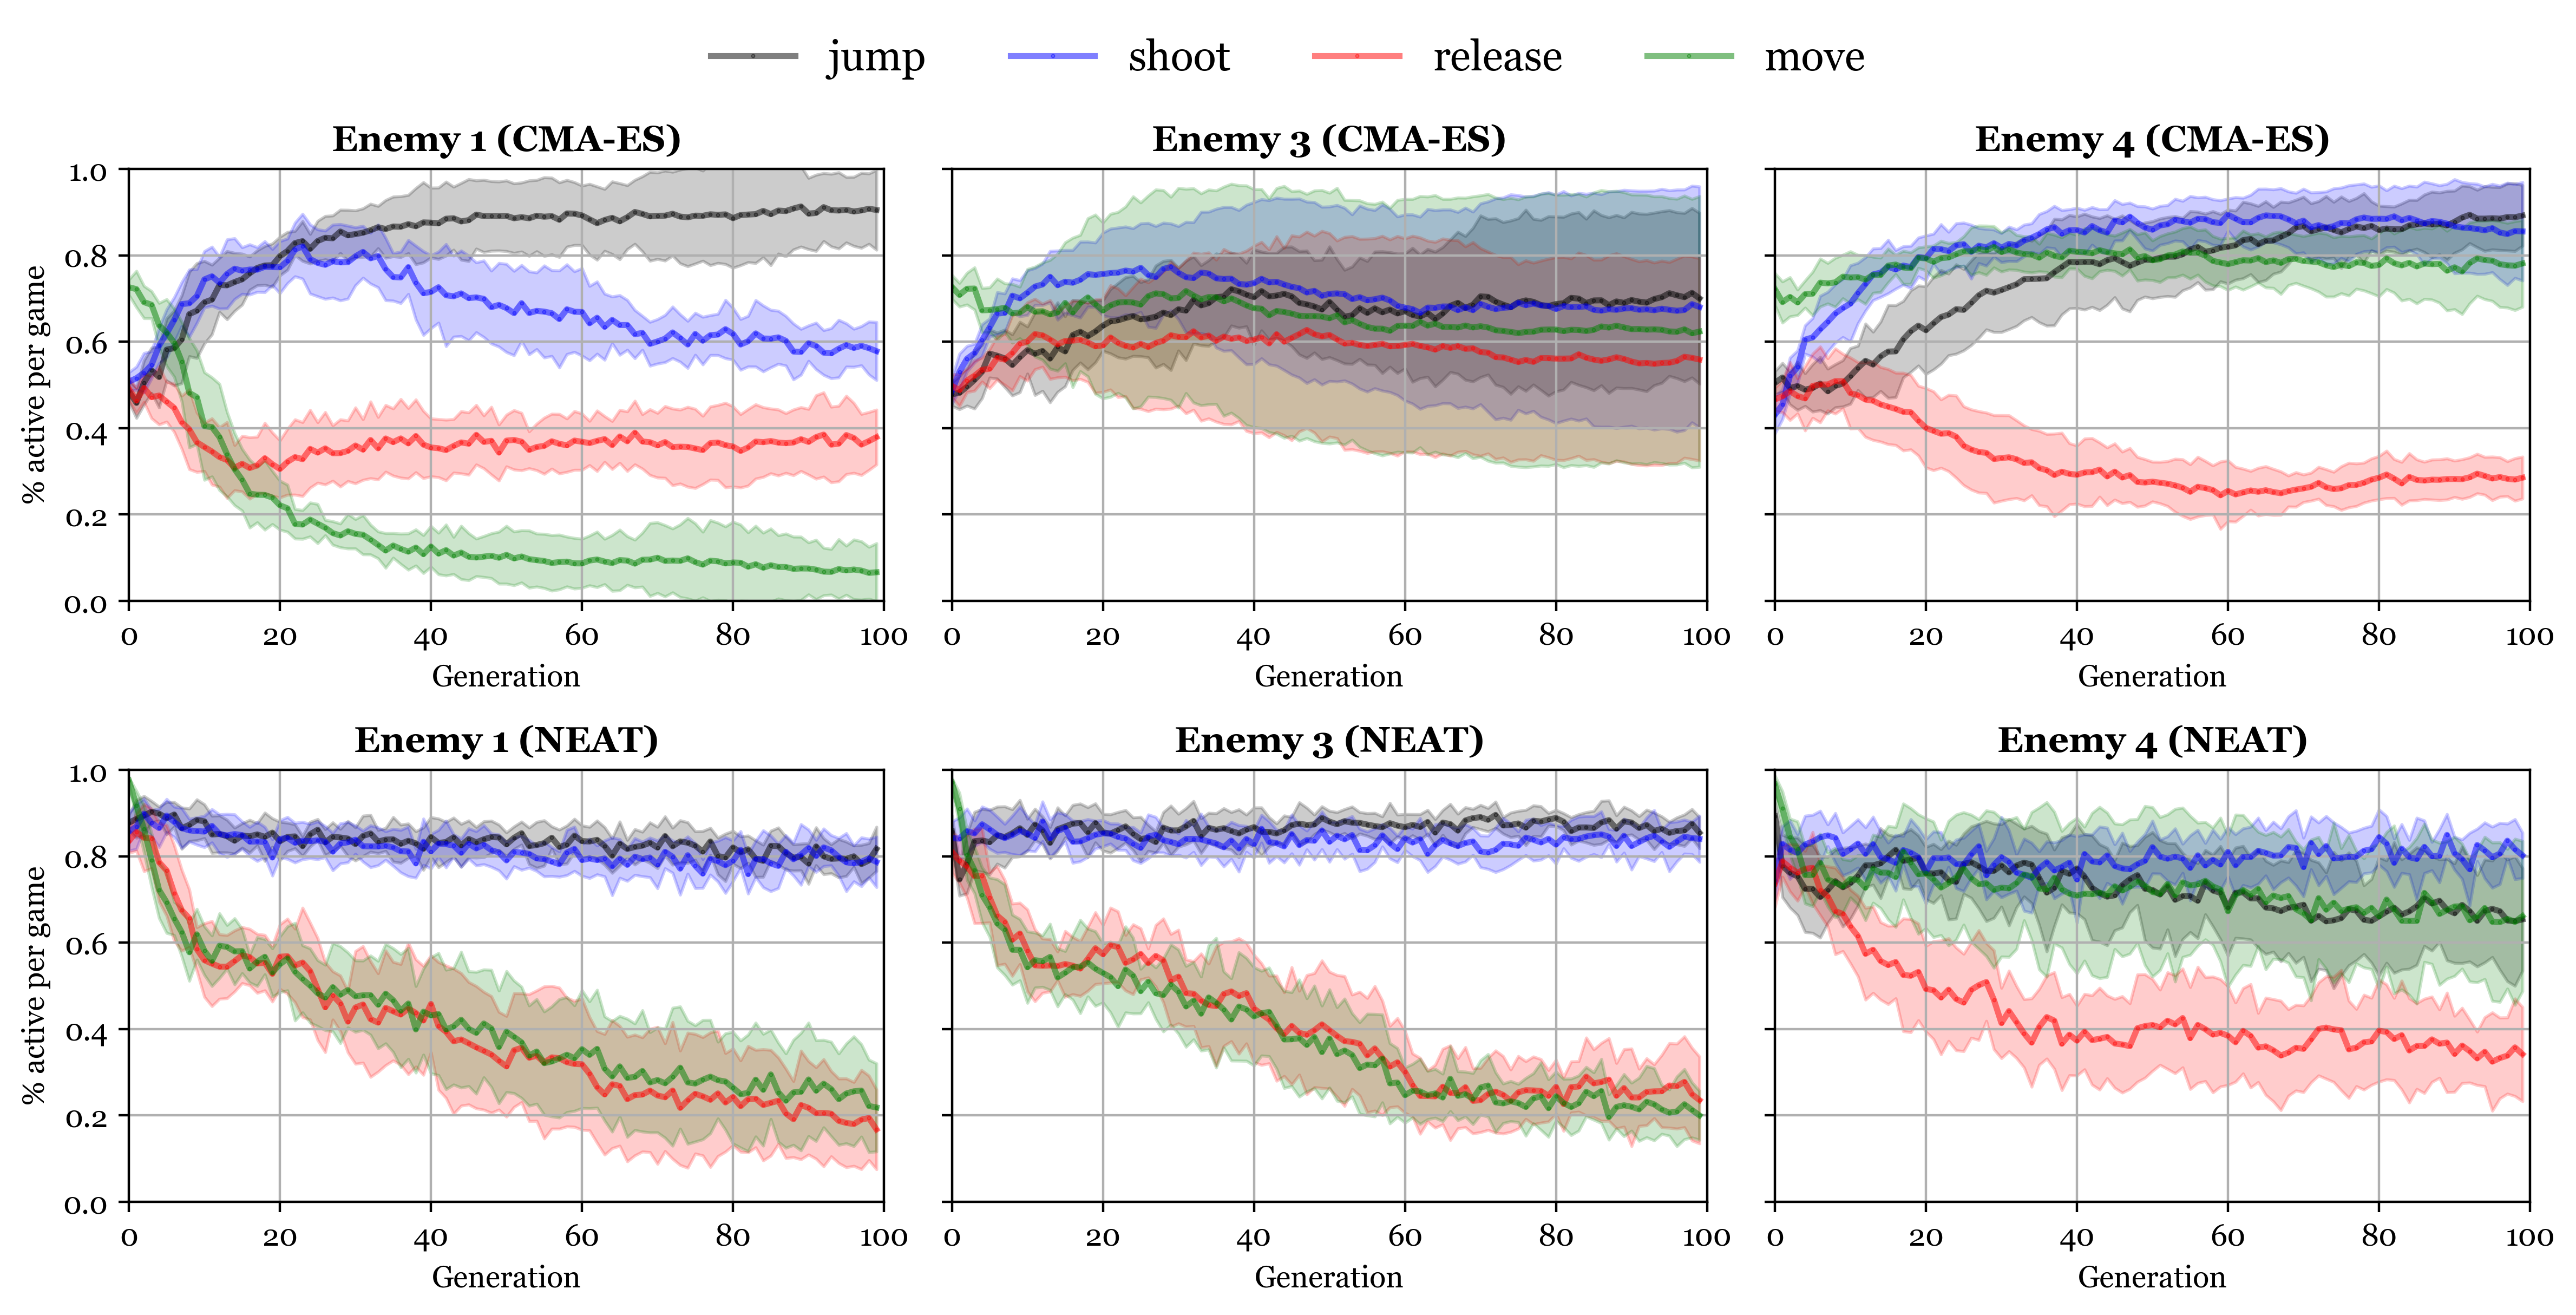

In [241]:
cmaes_decisions_mean = np.mean(cmaes_decisions, axis=1)
cmaes_decisions_std = np.std(cmaes_decisions, axis=1)
neat_decisions_mean = np.mean(neat_decisions, axis=1)
neat_decisions_std = np.std(neat_decisions, axis=1)

mpl.rc('font', size=10)

ALGORITHMS = ['CMA-ES', 'NEAT']
MOVES = ['left', 'right', 'jump', 'shoot', 'release', 'move', 'jump or release']
COLORS = ['black', 'blue', 'red', 'green']

fig, axes = plt.subplots(2, len(ENEMIES), figsize=(12, 6), dpi=400, sharey=True)

def plot_mean_with_sd(ax, xx, means, sds, color, label):
    line, = ax.plot(xx, means, alpha=0.5, lw=2, marker='.', ms=0.8, color=color, label=label)
    ax.fill_between(xx, means + sds, means - sds, color=color, alpha=0.2, edgecolor=color, linewidth=1)
    return line

for (k, alg) in enumerate(ALGORITHMS):
    for (i, enemy) in enumerate(ENEMIES):
        axes[k, i].set_ylim(0, 1.0)
        axes[k, i].set_yticks(np.arange(0, 1.01, 0.2))
        if i == 0:
        	axes[k, i].set_ylabel("% active per game")

        axes[k, i].set_xlim(0, n_gens)
        axes[k, i].set_xticks(np.arange(0, n_gens + 1, 20))
        axes[k, i].set_xlabel("Generation")

        axes[k, i].set_title(f"Enemy {enemy} ({alg})", weight="bold")
        axes[k, i].grid()

lines = []
labels = []
for (k, alg) in enumerate(ALGORITHMS):
    for i in range(len(ENEMIES)):
        for (j, move) in enumerate(MOVES[2:6], 2):
            xx = np.arange(n_gens)
            if k == 0:
                means = cmaes_decisions_mean[i, :, 0, j]
                sds = cmaes_decisions_std[i, :, 0, j]
            else:
                means = neat_decisions_mean[i, :, 0, j]
                sds = neat_decisions_std[i, :, 0, j]
            line = plot_mean_with_sd(axes[k, i], xx, means, sds, COLORS[j-2], move)
            if i == 0 and k == 0:
                lines.append(line)
                labels.append(move)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(lines, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize=14, frameon=False)
fig.savefig("figures/decision_convergence.png", dpi=400)
plt.show()